# Primer: Napovedovanje prevare pri garancijskem zahtevku

## Namestitev/posodobitev knjižnjic

In [1]:
!pip install -U seaborn
!pip install -U scikit-learn
!pip install -U neptune-client
!pip install -U neptune-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Vrednosti za dostop do storitev

In [2]:
PROJECT_NAME = "vase_uporabnisko_ime/ime_projekta"
API_TOKEN = "vas_api_token"
MODEL_NAME = "vase_ime_modela"


## Vključitev knjižnjic

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from google.colab import files
import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_utils
from neptune.new.exceptions import NeptuneModelKeyAlreadyExistsError

In [4]:
# Nastavitev velikosti izrisanih grafov

sns.set(rc = {'figure.figsize':(15,8)})

## Nalaganje podatkovne množice

*V primeru, da uporabljate brskalnik Firefox, kliknite na ikono ščita v vrstici z URL naslovom ter onemogočite **Enhanced Tracking Protection** funkcionalnost. V nasprotnem primeru vam nalaganje datotek ne bo delovalo.*

In [5]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving warranty_claims.csv to warranty_claims (2).csv
User uploaded file "warranty_claims.csv" with length 862678 bytes


In [6]:
# Nalaganje podatkovne množice v Pandas DataFrame
def load_dataset():
    return pd.read_csv("warranty_claims.csv")
    
df = load_dataset()

## Pregled podatkovne množice

In [7]:
df

,Area,Consumer_profile,Product_category,Product_type,AC_1001_Issue,AC_1002_Issue,AC_1003_Issue,TV_2001_Issue,TV_2002_Issue,TV_2003_Issue,Claim_Value,Service_Centre,Product_Age,Purchased_from,Call_details,Purpose,Fraud,ID
0,Rural,Personal,Household,AC,0.0,1.0,2.0,0.0,0.0,0.0,4474.0,12.0,202.0,Manufacturer,30.0,Claim,0,7957.0
1,Urban,Personal,Entertainment,TV,0.0,0.0,0.0,1.0,1.0,1.0,25000.0,13.0,60.0,Dealer,1.3,Complaint,0,1396.0
2,Rural,Business,Household,AC,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,12.0,3.0,Dealer,2.5,Claim,0,7582.0
3,Rural,Personal,Entertainment,TV,0.0,0.0,0.0,1.0,1.0,0.0,4216.0,10.0,672.0,Dealer,25.0,Other,0,5824.0
4,Rural,Business,Household,AC,0.0,0.0,0.0,0.0,0.0,0.0,20000.0,13.0,3.0,Manufacturer,6.5,Claim,0,4086.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8336,Urban,Personal,Household,AC,0.0,1.0,1.0,0.0,0.0,0.0,10000.0,14.0,15.0,Dealer,2.6,Claim,0,1939.0
8337,Rural,Personal,Household,AC,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,13.0,4.0,Manufacturer,1.3,Complaint,0,390.0
8338,Urban,Personal,Household,AC,0.0,1.0,0.0,0.0,0.0,0.0,2000.0,12.0,61.0,Dealer,24.0,Claim,0,835.0
8339,Urban,Personal,Household,AC,1.0,1.0,1.0,0.0,0.0,0.0,6000.0,15.0,280.0,Dealer,21.0,Complaint,0,3036.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              8341 non-null   object 
 1   Consumer_profile  8341 non-null   object 
 2   Product_category  8341 non-null   object 
 3   Product_type      8341 non-null   object 
 4   AC_1001_Issue     8341 non-null   float64
 5   AC_1002_Issue     8341 non-null   float64
 6   AC_1003_Issue     8341 non-null   float64
 7   TV_2001_Issue     8341 non-null   float64
 8   TV_2002_Issue     8341 non-null   float64
 9   TV_2003_Issue     8341 non-null   float64
 10  Claim_Value       8101 non-null   float64
 11  Service_Centre    8341 non-null   float64
 12  Product_Age       8341 non-null   float64
 13  Purchased_from    8341 non-null   object 
 14  Call_details      8341 non-null   float64
 15  Purpose           8341 non-null   object 
 16  Fraud             8341 non-null   int64  


### Porazdelitev razredov

Z uporabo knjižnjice Seaborn bomo izrisali stolpične diagrame števila primerkov kjer je bila identificirana prevara pri uveljavitvi škodnega zahtevka in števila primerkov kjer ni bila.

[Text(0.5, 1.0, 'Porazdelitev izhodnih razredov')]

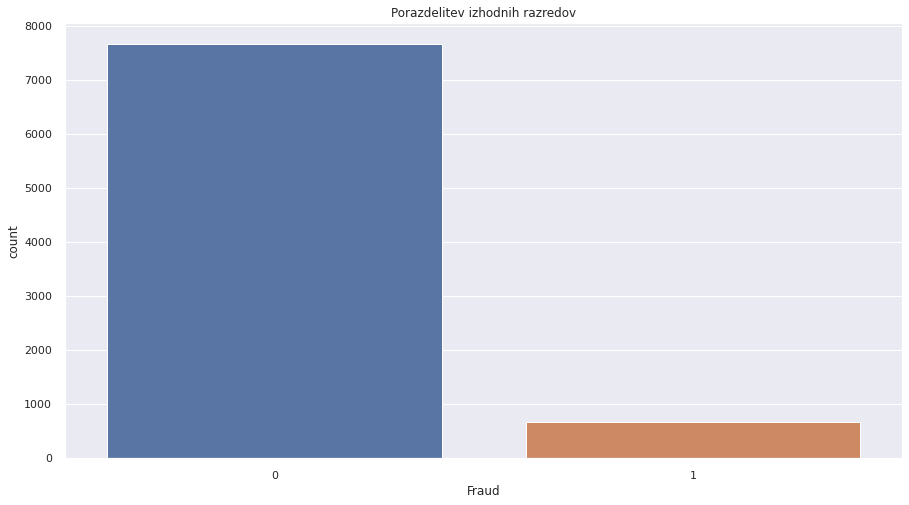

In [9]:
sns.countplot(data=df, x ='Fraud').set(title='Porazdelitev izhodnih razredov')

Glede na število primerkov posazmenega izhodnega razreda (**Fraud**) ugotovimo, da podatkovna množica ni uravnotežena.

### Analiza posameznih značilnic glede na izhodni razred

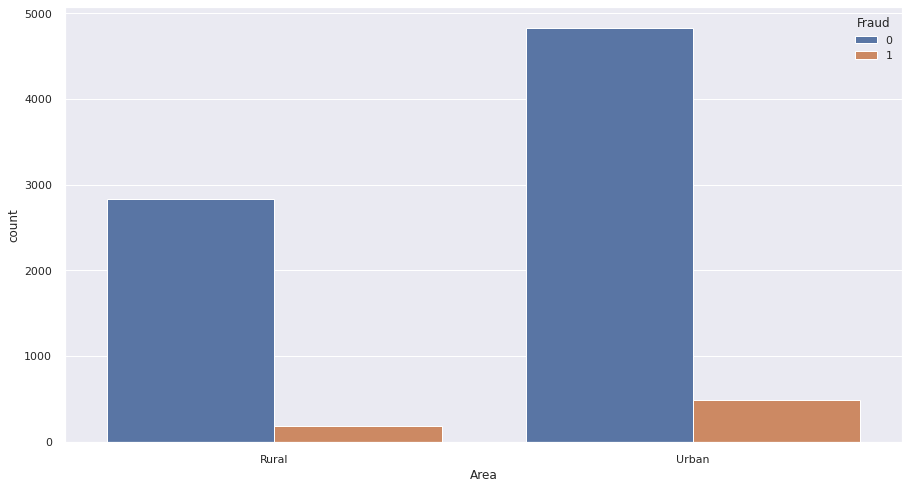

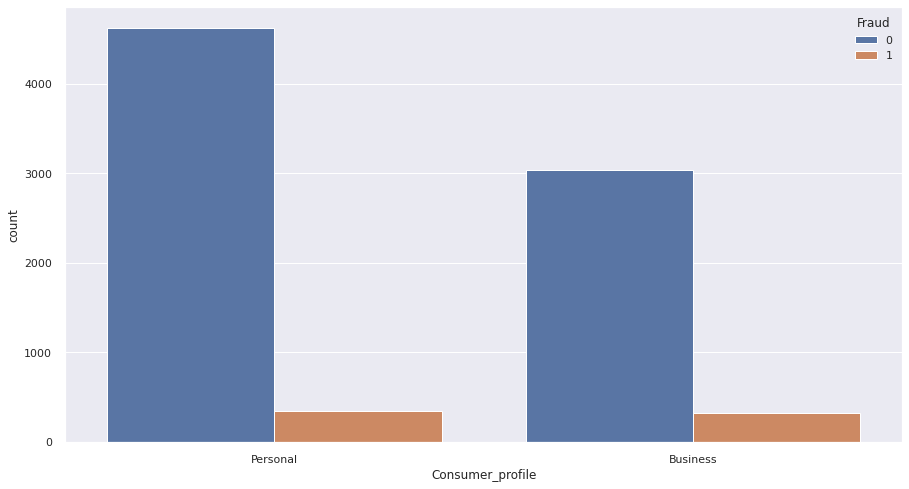

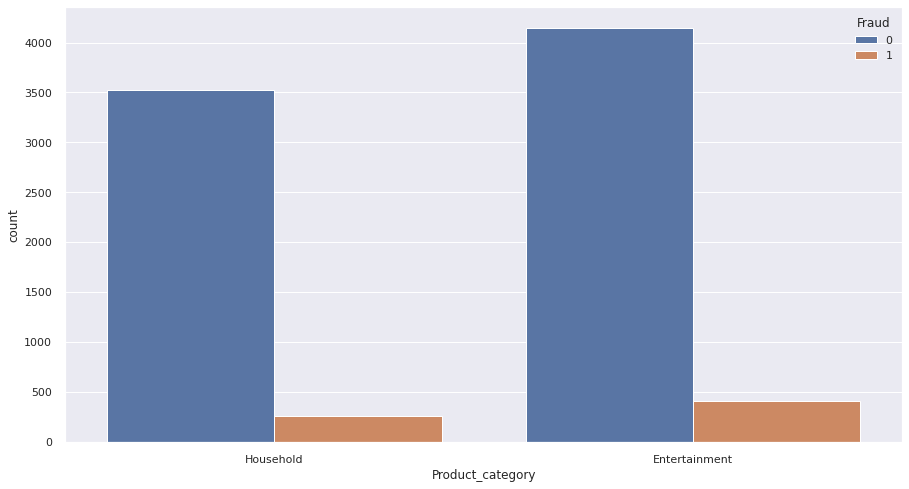

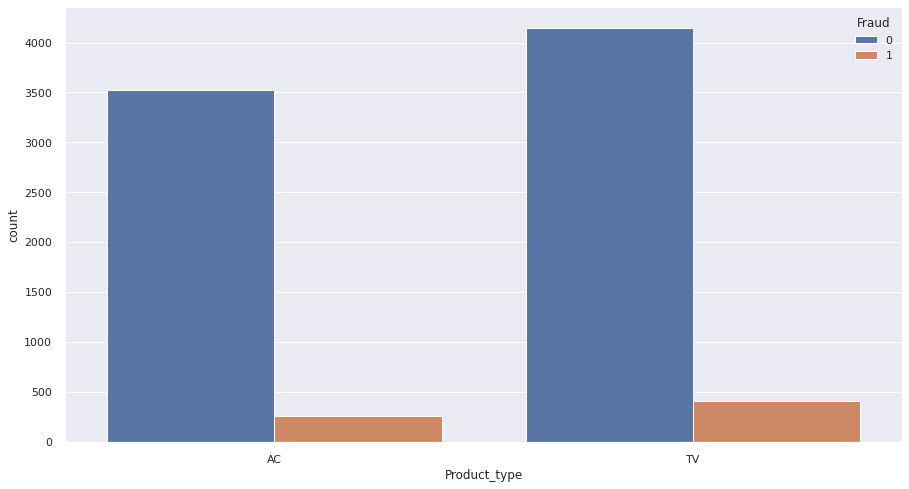

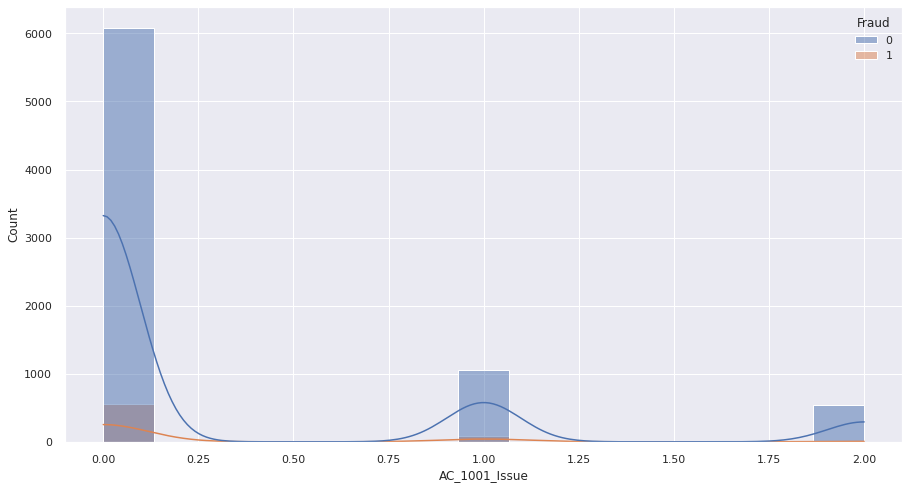

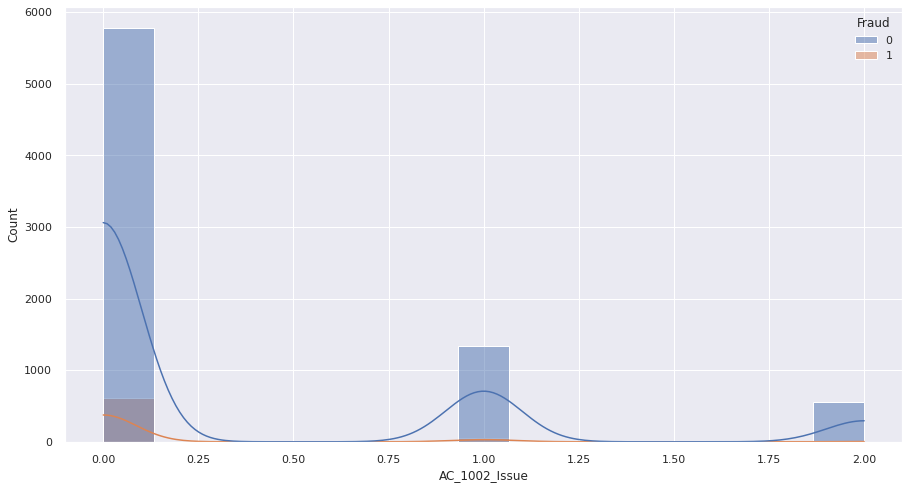

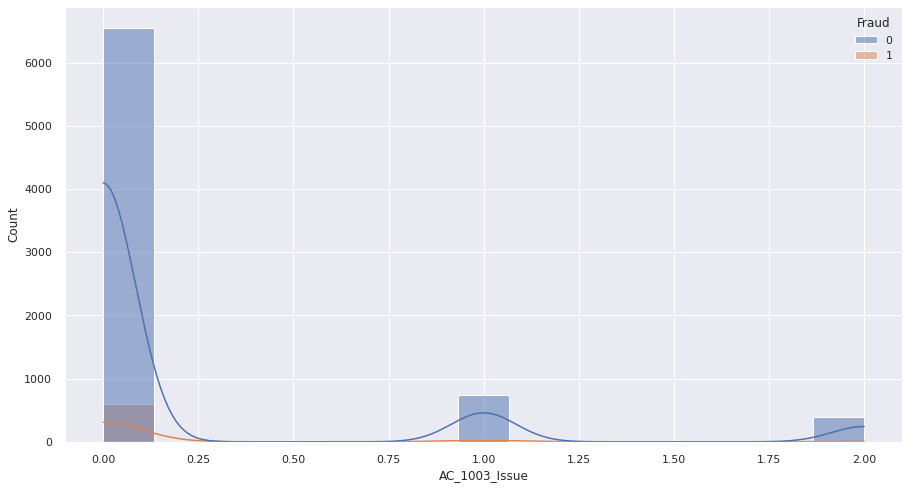

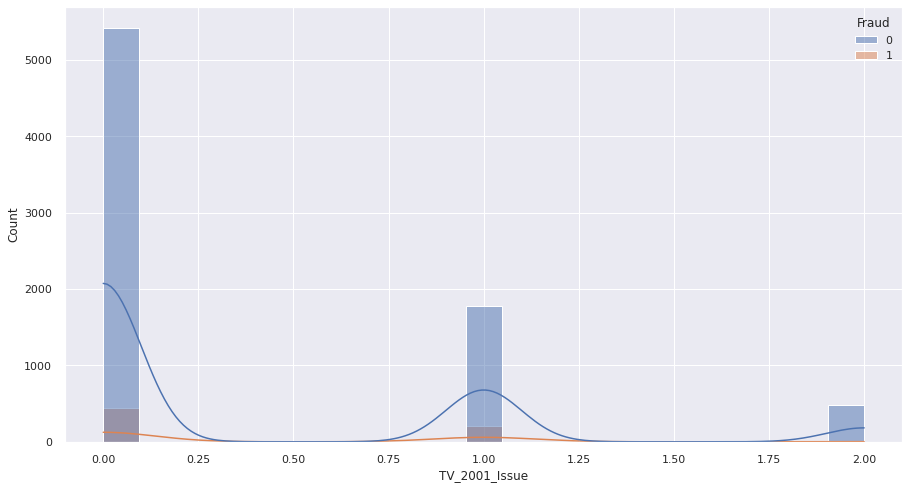

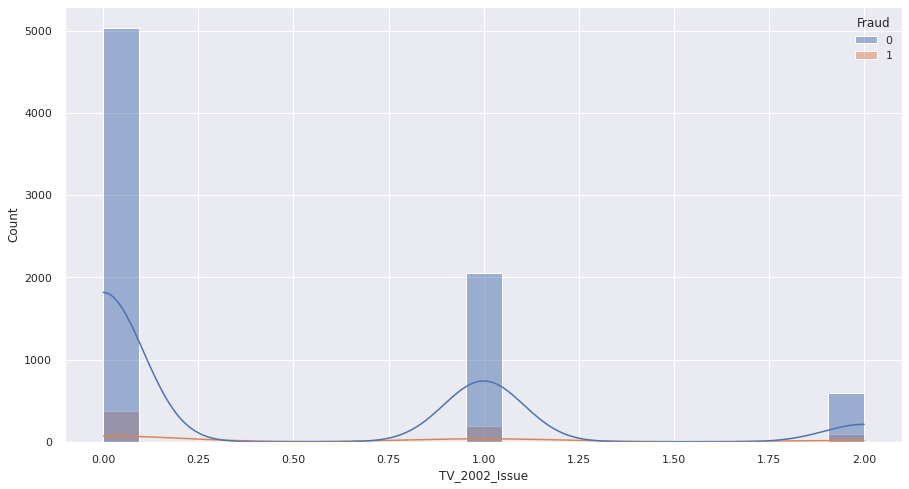

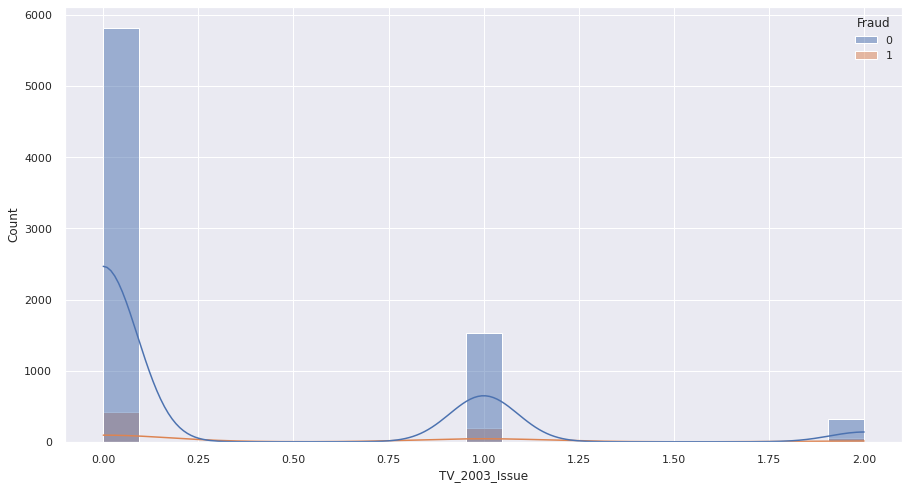

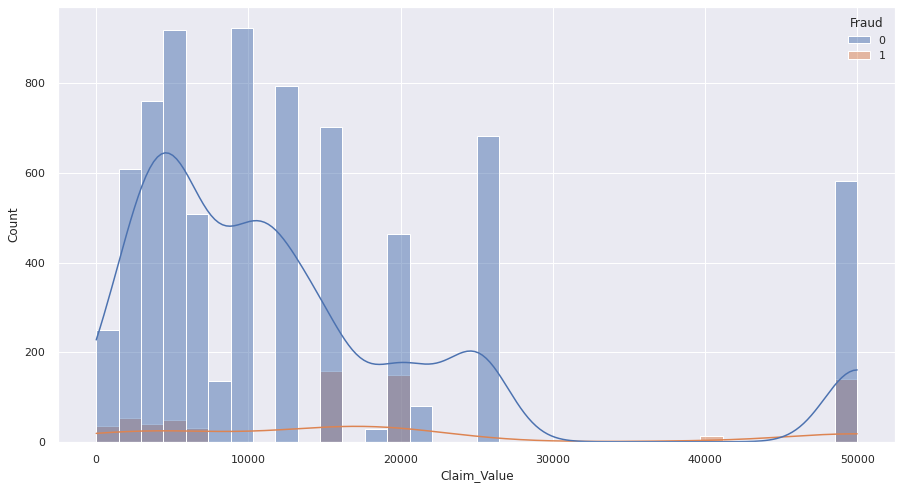

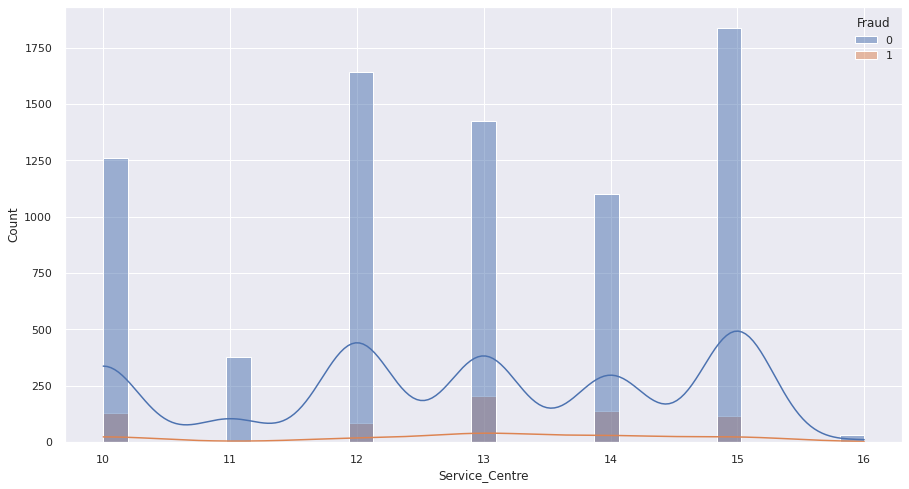

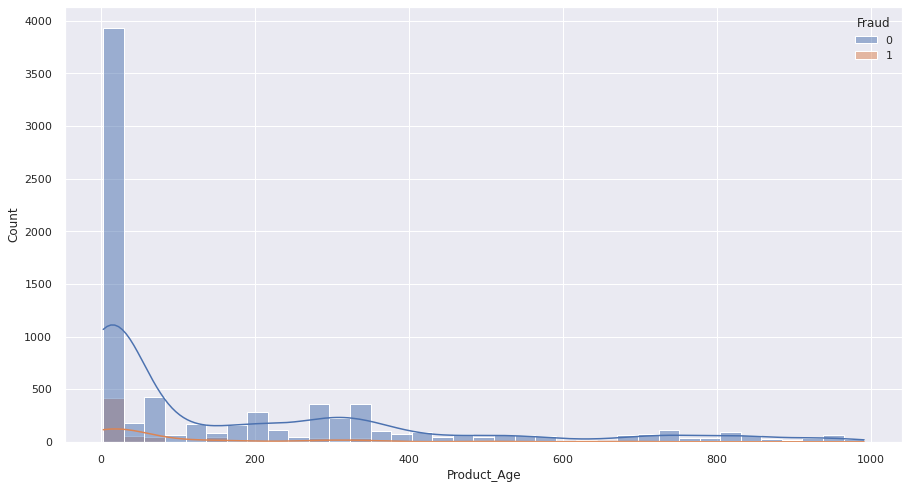

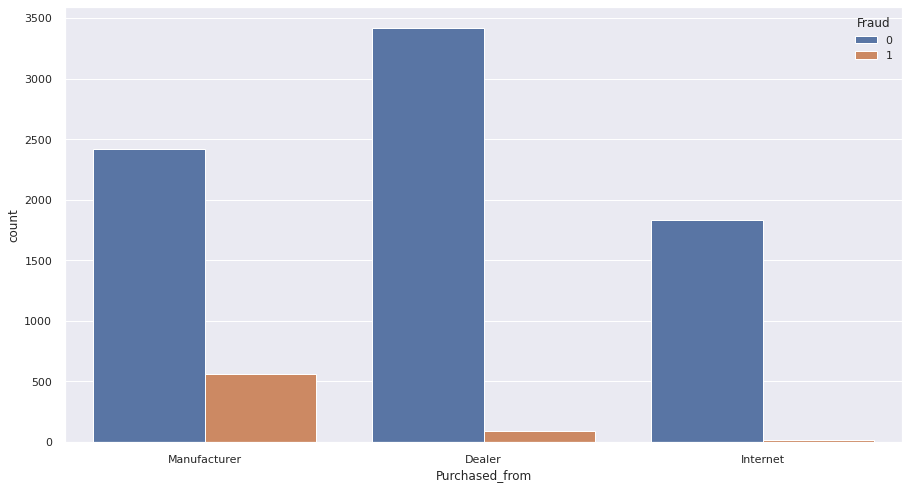

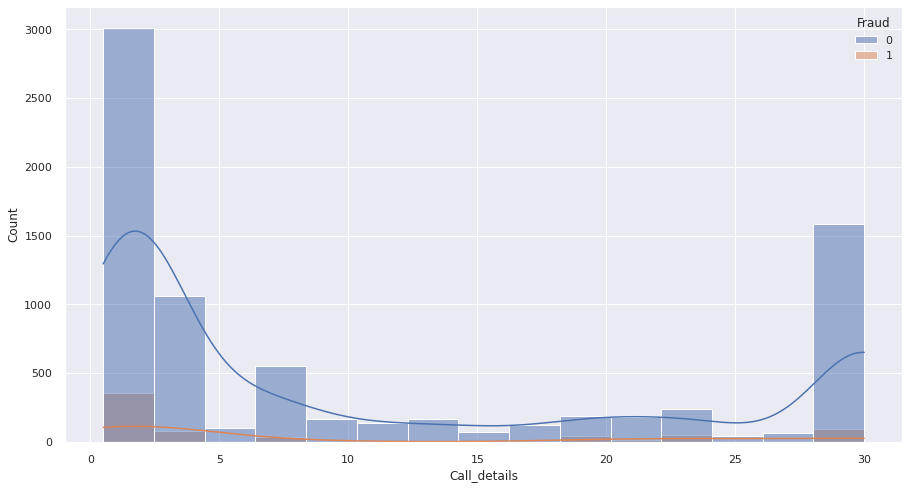

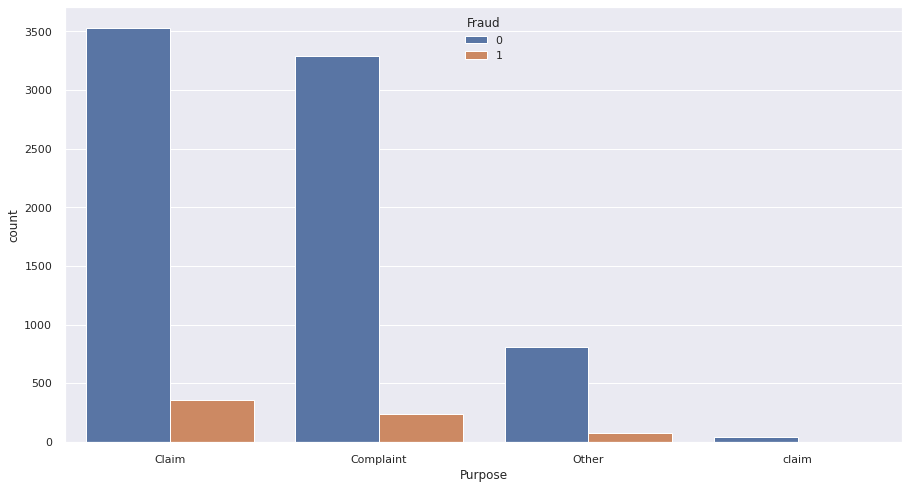

In [10]:
for feature in df.columns.values:
    if feature in ["Area", "Consumer_profile", "Product_category", "Product_type", "Purchased_from", "Purpose"]:
        plt.figure()
        sns.countplot(data=df, x=feature, hue="Fraud")
    else:
        if feature not in ["ID", "Fraud"]:
            plt.figure()
            sns.histplot(data=df, x=feature, hue="Fraud", kde=True)

## Pred-procesiranje podatkovne množice

V sklopu tega procesa, bomo:
- preverili in po potrebi zapolnili manjkajoče vrednosti za posamezno značilnico
- odstranili morebitne odvečne oz. nepotrebne vrednosti
- razdelili podatkovno množico na učno in testno
- značilnice, ki imajo kategoričen nabor vrednosti pretvorili

### Pregled vrednosti značilnic

Pregledamo ali ima kakšen primerek manjkajočo vrednost posamezne značilnice. 

In [11]:
df.isnull().sum()

Area                  0
Consumer_profile      0
Product_category      0
Product_type          0
AC_1001_Issue         0
AC_1002_Issue         0
AC_1003_Issue         0
TV_2001_Issue         0
TV_2002_Issue         0
TV_2003_Issue         0
Claim_Value         240
Service_Centre        0
Product_Age           0
Purchased_from        0
Call_details          0
Purpose               0
Fraud                 0
ID                    0
dtype: int64

### Zapolnitev manjkajočih vrednosti

Za vsak primerek, ki ima manjkajočo vrednost značilnice **ANNUAL_KM**, bomo to priredili vrednosti mediane množice vseh primerkov. 

In [12]:
df["Claim_Value"] = df["Claim_Value"].fillna(df["Claim_Value"].median())
df.isnull().sum()

Area                0
Consumer_profile    0
Product_category    0
Product_type        0
AC_1001_Issue       0
AC_1002_Issue       0
AC_1003_Issue       0
TV_2001_Issue       0
TV_2002_Issue       0
TV_2003_Issue       0
Claim_Value         0
Service_Centre      0
Product_Age         0
Purchased_from      0
Call_details        0
Purpose             0
Fraud               0
ID                  0
dtype: int64

### Odstranitev odvečnih/nepotrebnih vrednosti

Iz podatkovne množice bomo odstranili stolpec **ID** saj je nepomemben za učenje napovednega modela.

In [13]:
df = df.drop(["ID"], axis=1)

In [14]:
df

,Area,Consumer_profile,Product_category,Product_type,AC_1001_Issue,AC_1002_Issue,AC_1003_Issue,TV_2001_Issue,TV_2002_Issue,TV_2003_Issue,Claim_Value,Service_Centre,Product_Age,Purchased_from,Call_details,Purpose,Fraud
0,Rural,Personal,Household,AC,0.0,1.0,2.0,0.0,0.0,0.0,4474.0,12.0,202.0,Manufacturer,30.0,Claim,0
1,Urban,Personal,Entertainment,TV,0.0,0.0,0.0,1.0,1.0,1.0,25000.0,13.0,60.0,Dealer,1.3,Complaint,0
2,Rural,Business,Household,AC,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,12.0,3.0,Dealer,2.5,Claim,0
3,Rural,Personal,Entertainment,TV,0.0,0.0,0.0,1.0,1.0,0.0,4216.0,10.0,672.0,Dealer,25.0,Other,0
4,Rural,Business,Household,AC,0.0,0.0,0.0,0.0,0.0,0.0,20000.0,13.0,3.0,Manufacturer,6.5,Claim,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8336,Urban,Personal,Household,AC,0.0,1.0,1.0,0.0,0.0,0.0,10000.0,14.0,15.0,Dealer,2.6,Claim,0
8337,Rural,Personal,Household,AC,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,13.0,4.0,Manufacturer,1.3,Complaint,0
8338,Urban,Personal,Household,AC,0.0,1.0,0.0,0.0,0.0,0.0,2000.0,12.0,61.0,Dealer,24.0,Claim,0
8339,Urban,Personal,Household,AC,1.0,1.0,1.0,0.0,0.0,0.0,6000.0,15.0,280.0,Dealer,21.0,Complaint,0


### Razdelitev podatkovne množice

Poznamo več načinov razdelitve podatkovne množice za name učenja in testiranja. Mi bomo v tem primeru uporabili najbolj osnovno delitev in sicer na učno in testno množico v razmerju 80:20.

In [15]:
# Ponovno naložimo podatkovno zbirko za kasnejšo implementacijo z uporabo cevovodov
load_dataset()

X = df.drop(["Fraud"], axis=1) # značilnice primerkov 
y = df["Fraud"] # ciljni razred posameznega primerka

# razdelitev podatkovne množice na učno in testno množico
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

### Zapolnitev manjkajočih vrednosti in predprocesiranje - sklearn pipeline

In [16]:
set_config(display='diagram')

numeric_transformer = Pipeline([
    ("fillna", SimpleImputer(strategy="mean")),
    ("standardize", StandardScaler())
])

categorical_transformer = Pipeline([
    ("one_hot", OneHotEncoder())
])

preprocessor =  ColumnTransformer([
    ("numeric_transformer", numeric_transformer, ["AC_1001_Issue", "AC_1002_Issue", "AC_1003_Issue", "TV_2001_Issue", "TV_2002_Issue", "TV_2003_Issue", "Claim_Value", "Service_Centre", "Product_Age", "Call_details"]),
    ("categorical_transformer", categorical_transformer, ["Area", "Consumer_profile", "Product_category", "Product_type", "Purchased_from", "Purpose"])
])

preprocessor


ColumnTransformer(transformers=[('numeric_transformer',
                                 Pipeline(steps=[('fillna', SimpleImputer()),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 ['AC_1001_Issue', 'AC_1002_Issue',
                                  'AC_1003_Issue', 'TV_2001_Issue',
                                  'TV_2002_Issue', 'TV_2003_Issue',
                                  'Claim_Value', 'Service_Centre',
                                  'Product_Age', 'Call_details']),
                                ('categorical_transformer',
                                 Pipeline(steps=[('one_hot', OneHotEncoder())]),
                                 ['Area', 'Consumer_profile',
                                  'Product_category', 'Product_type',
                                  'Purchased_from', 'Purpose'])])

In [17]:
# izvedemo pred-procesiranje z uporabo sklearn cevovoda
preprocessor.fit_transform(X_train)

array([[-0.46725635, -0.51347199, -0.37629984, ...,  0.        ,
         0.        ,  0.        ],
       [-0.46725635,  1.18925421,  1.63545701, ...,  1.        ,
         0.        ,  0.        ],
       [-0.46725635, -0.51347199, -0.37629984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.03953148,  2.8919804 ,  3.64721385, ...,  0.        ,
         0.        ,  0.        ],
       [-0.46725635, -0.51347199, -0.37629984, ...,  1.        ,
         0.        ,  0.        ],
       [-0.46725635, -0.51347199, -0.37629984, ...,  1.        ,
         0.        ,  0.        ]])

## Večslojni perceptron

Večslojni perceptron (angl. multilayer perceptron, MLP), je polno povezan razred naprej usmerjenih (angl. feedforward) umetnih nevronskih mrež (angl. artificial neural network, ANN).

Termin MLP se uporablja dvoumno, včasih tudi ohlapno za označevanje katere koli ANN, včasih pa se uporablja za strogo sklicevanje na mreže sestavljene iz več plasti perceptronov ob uporabi aktivacijske funkcije. Večplastne perceptrone včasih pogovorno imenujemo "vanilla" nevronske mreže, še posebej, če imajo eno samo skrito plast.

MLP je sestavljen iz vsaj treh slojev vozlišč: vhodne plasti, skrite plasti in izhodne plasti. Razen vhodnih vozlišč je vsako vozlišče nevron, ki uporablja nelinearno aktivacijsko funkcijo.

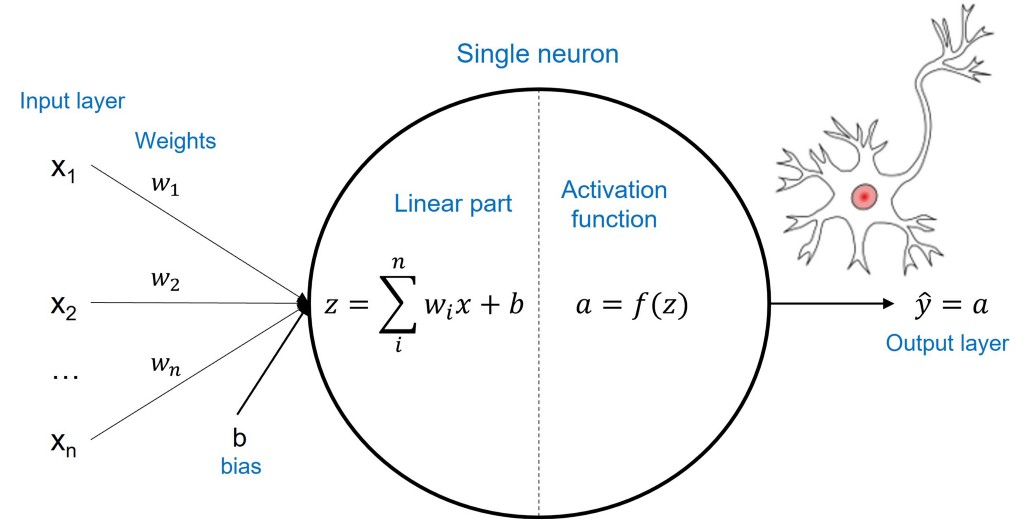

**Primer arhitekture večslojnega perceptrona:**

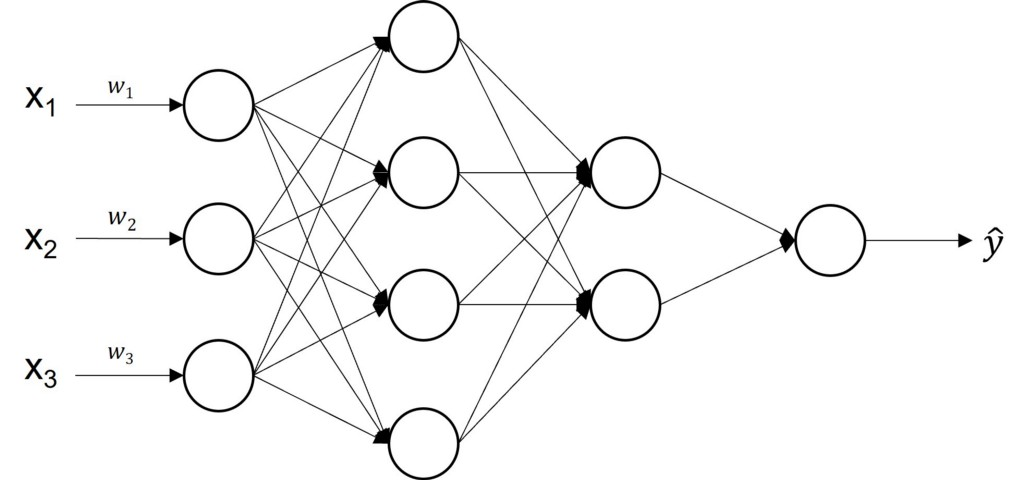

MLP za učenje uporablja tehniko nadzorovanega učenja imenovano vzvratno razširjanje (angl. backpropagation) napake.

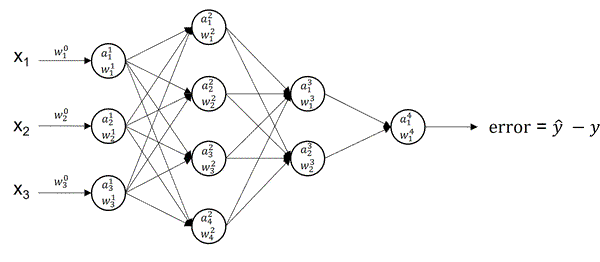

Večslojni perceptron ima sposobnost razlikovati (razvrščati) podatke, ki sicer niso linearno ločljivi. 

In [18]:
from IPython.display import IFrame
IFrame(
    "https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.87776&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=true&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false",
    1024,
    768
)

## Učenje napovednega modela nevronske mreže



In [19]:
pipe = Pipeline([
    ("preprocess", preprocessor),
    (
        "MLP",
        MLPClassifier()
    )
])

pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('fillna',
                                                                   SimpleImputer()),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['AC_1001_Issue',
                                                   'AC_1002_Issue',
                                                   'AC_1003_Issue',
                                                   'TV_2001_Issue',
                                                   'TV_2002_Issue',
                                                   'TV_2003_Issue',
                                                   'Claim_Value',
                                                   'Service_Centre',
                                                   'Product_Age',
                                                   'Call_details']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['Area', 'Consumer_profile',
                                                   'Product_category',
                                                   'Product_type',
                                                   'Purchased_from',
                                                   'Purpose'])])),
                ('MLP', MLPClassifier())])

In [20]:
pipe.fit(X_train, y_train)
print(f"Točnost nad testno množico: {pipe.score(X_test, y_test)}")

Točnost nad testno množico: 0.9766327142001199


### Nastavitev učnih parametrov (hiperparametrov)

In [21]:
parameters = {
    "solver": "adam",
    "hidden_layer_sizes": (24,16),
    "random_state": 1234
}

pipe = Pipeline([
    ("preprocess", preprocessor),
    (
        "MLP",
        MLPClassifier(**parameters)
    )
])

pipe.fit(X_train, y_train)
print(f"Točnost nad testno množico: {pipe.score(X_test, y_test)}")

Točnost nad testno množico: 0.975434391851408


## Ovrednotenje napovednega modela

In [22]:
# pridobimo napovedane vrednosti y za testne primerke
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1550
           1       0.77      0.93      0.84       119

    accuracy                           0.98      1669
   macro avg       0.88      0.96      0.92      1669
weighted avg       0.98      0.98      0.98      1669



## Sledenje eksperimentov
- Integracija z neptune.ai
- Register modelov

### Integracija z neptune.ai

Učenje modela s privzetimi nastavitvami

In [23]:
# Integracija z neptune.ai
run = neptune.init(
    project=PROJECT_NAME,
    api_token=API_TOKEN
)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("MLP", MLPClassifier())
])

pipe.fit(X_train, y_train)

# Beleženje točnosti na testno podmnožico
test_acc = pipe.score(X_test, y_test)
run["test_accuracy"] = test_acc

# Beleženje uspešnosti naučenega napovednega modela
run["classifier"] = npt_utils.create_classifier_summary(
    pipe, X_train, X_test, y_train, y_test
)

run.stop()

https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/e/PRIMER-20


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 80 operations to synchronize with Neptune. Do not kill this process.


Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.


All 80 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/e/PRIMER-20


Učenje modela s ročno nastavljenimi vrednostmi hiperparametrov

In [24]:
run = neptune.init(
    project=PROJECT_NAME,
    api_token=API_TOKEN
)

pipe = Pipeline([
    ("preprocess", preprocessor),
    (
        "MLP",
        MLPClassifier(**parameters)
    )
])

# Beleženje uporabljenih učnih parametrov
run["parameters"] = parameters

pipe.fit(X_train, y_train)

# Beleženje točnosti na testno podmnožico
test_acc = pipe.score(X_test, y_test)
run["test_accuracy"] = test_acc

# Beleženje uspešnosti naučenega napovednega modela
run["classifier"] = npt_utils.create_classifier_summary(
    pipe, X_train, X_test, y_train, y_test
)

run.stop()

https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/e/PRIMER-21
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 88 operations to synchronize with Neptune. Do not kill this process.


Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.


All 88 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/e/PRIMER-21


### Register modelov

In [25]:
# Serializiramo model (pipe)

with open("model.pickle", "wb") as file:
  pickle.dump(pipe, file, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
# Inicializiramo model, če še ne obstaja

model = None

try:
  model = neptune.init_model(
      project=PROJECT_NAME,
      api_token=API_TOKEN,
      name="MLP classifier",
      key="MLP",
  )
except NeptuneModelKeyAlreadyExistsError:
  print("Model s ključem že obstaja.")
finally:
  if model is not None:
    model.stop()



Model s ključem že obstaja.


In [27]:
# Ustvarimo novo verzijo modela

model_version = neptune.init_model_version(
    model=MODEL_NAME,
    project=PROJECT_NAME,
    api_token=API_TOKEN
)

model_version["model"].upload("model.pickle")
model_version["test/acc"] = test_acc

model_version.stop()


https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/m/PRIMER-MLP/v/PRIMER-MLP-5
Remember to stop your model_version once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/model-version#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/m/PRIMER-MLP/v/PRIMER-MLP-5/metadata


## Bonus: Optimizacija hiperparametrov MLP

In [28]:
# Iskalni prostor parametrov
parameter_space = {
    "MLP__hidden_layer_sizes": [(100),(64),(32),(16),(32,16)],
    "MLP__activation": ["tanh", "relu"],
    "MLP__solver": ["sgd", "adam", "lbfgs"],
    "MLP__learning_rate_init": [0.001, 0.01]
}

In [29]:
search = GridSearchCV(pipe, parameter_space, verbose=2)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_:.3f})")
print(search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=  10.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=  10.6s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=  10.3s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=  11.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=  11.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=  11.5s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   4.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.1s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.4s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.7s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=  10.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=  10.8s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   4.4s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   4.3s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.4s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.4s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.8s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   3.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; to

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   8.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   8.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   8.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   8.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   8.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=  10.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   8.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   7.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   8.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   8.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.2s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.3s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.5s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.3s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   8.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   8.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   8.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   8.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   8.3s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.3s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   4.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.2s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.4s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.1s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   2.2s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   4.1s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   1.8s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   1.7s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.5s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   1.8s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.7s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.2s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.8s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.8s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.7s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   1.8s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.1s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.7s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.7s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.6s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   2.4s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   3.7s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   2.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   4.2s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   4.5s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   4.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   4.5s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   4.9s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   4.1s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   4.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   5.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   4.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   5.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.7s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.2s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.6s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.8s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   4.5s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   5.0s
[CV] END MLP__activation=tanh, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   4.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   7.4s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   7.1s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   7.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   7.9s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   6.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   7.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   4.0s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   4.6s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.4s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.001, MLP__solv

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   7.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   7.3s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.3s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.9s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.7s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   5.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=100, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; to

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   6.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   6.3s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   6.1s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   5.6s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   5.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   6.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.7s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.6s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   6.0s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.3s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.0s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.9s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.4s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.6s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   3.7s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=64, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.9s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   2.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.0s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.4s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   0.8s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.0s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.4s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   3.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=32, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   2.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   5.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   5.6s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.7s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   5.3s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   2.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.7s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.4s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.4s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   5.6s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   3.7s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   4.0s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=16, MLP__learning_rate_init=0.01, MLP__solver=lbfgs; total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=sgd; total time=   3.9s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   2.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.6s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.5s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=adam; total time=   3.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.001, MLP__solver=lbfgs; total time=   4.9s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP_

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.8s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=sgd; total time=   3.6s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.4s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   2.0s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.3s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   1.2s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning_rate_init=0.01, MLP__solver=adam; total time=   3.3s
[CV] END MLP__activation=relu, MLP__hidden_layer_sizes=(32, 16), MLP__learning

In [30]:
best_hyperparameters = {}

for key, value in search.best_params_.items():
  best_hyperparameters[key[5:]] = value

print(best_hyperparameters)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("MLP", MLPClassifier(**best_hyperparameters))
])

run = neptune.init(
    project=PROJECT_NAME,
    api_token=API_TOKEN)

# Beleženje uporabljenih učnih parametrov
run["parameters"] = best_hyperparameters

pipe.fit(X_train, y_train)

# Beleženje točnosti na testno podmnožico
test_acc = pipe.score(X_test, y_test)
run["test_accuracy"] = test_acc

# Beleženje uspešnosti naučenega napovednega modela
run["classifier"] = npt_utils.create_classifier_summary(
    pipe, X_train, X_test, y_train, y_test
)

run.stop()

{'activation': 'relu', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01, 'solver': 'adam'}
https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/e/PRIMER-23
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 89 operations to synchronize with Neptune. Do not kill this process.


Error occurred during asynchronous operation processing: Value of float attribute cannot be malformed.


All 89 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/e/PRIMER-23


In [31]:
# Serializiramo model (pipe)

with open("model.pickle", "wb") as file:
  pickle.dump(pipe, file, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
# Ustvarimo novo verzijo modela

model_version = neptune.init_model_version(
    model=MODEL_NAME,
    project=PROJECT_NAME,
    api_token=API_TOKEN
)

model_version["model"].upload("model.pickle")
model_version["test/acc"] = test_acc

model_version.stop()

https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/m/PRIMER-MLP/v/PRIMER-MLP-6
Remember to stop your model_version once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/model-version#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/gregavrbancic/poletna-sola-2022-primer/m/PRIMER-MLP/v/PRIMER-MLP-6/metadata
